In [1]:
import os, sys

import sgpp, sgml, dproc, sgutil
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(sys.version)

from sklearn.pipeline import make_pipeline

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]


In [2]:
sc = sgutil.SGCache('img', 'result', 'model')
p = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.ExprProcessor({
        'ELm_num': (pl.col('Episode_Length_minutes').clip(5, 120) - 5) / 115,
        'GP': (pl.col('Guest_Popularity_percentage').fill_null(pl.col('Guest_Popularity_percentage').clip(0,100).mean()).clip(0, 100) / 100),
        'HP': pl.col('Host_Popularity_percentage').clip(0, 100) / 100,
        'NAd': (pl.when(pl.col('Number_of_Ads') > 4).then(0).otherwise(pl.col('Number_of_Ads'))).fill_null(0.0) /3 ,
        'Number_of_Ads': (pl.when(pl.col('Number_of_Ads') > 4).then(0).otherwise(pl.col('Number_of_Ads'))).fill_null(0).cast(pl.Int8),
        'ELm_na': pl.col('Episode_Length_minutes').is_null(),
        'GPp_na': pl.col('Guest_Popularity_percentage').is_null(),
        'ELm_sqrt': ((pl.col('Episode_Length_minutes').clip(5, 120) - 5) / 115)  ** 0.5
    }),
    sgpp.PandasConverter(index_col = 'id')
)
p.fit(['data/train.csv'])
df_train = p.transform(['data/train.csv'])
df_test = p.transform(['data/test.csv'])
target = 'Listening_Time_minutes'
X_all = [i for i in df_train.columns if i != target]

In [13]:
from sklearn.model_selection import train_test_split
df_train_1, df_test_1 = train_test_split(df_train, train_size = 0.75, random_state = 123, shuffle = True)

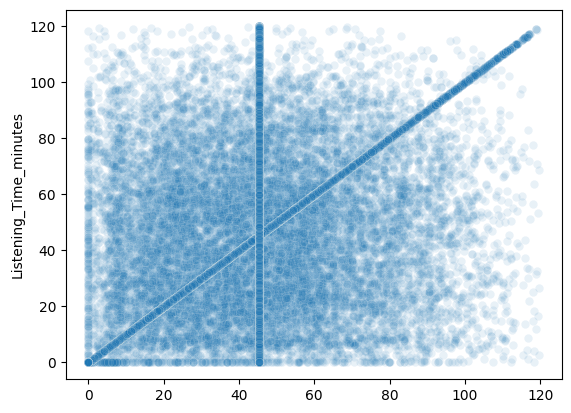

In [46]:
from sklearn.preprocessing import TargetEncoder
tge = TargetEncoder()
sns.scatterplot(
    x = tge.fit_transform(
        df_train_1[['Episode_Title', 'Host_Popularity_percentage', 'Guest_Popularity_percentage']].astype('str').sum(axis = 1).rename('c').to_frame(), 
        df_train_1[target]
    )[:, 0],
    y = df_train_1[target], alpha = 0.1
)
plt.show()

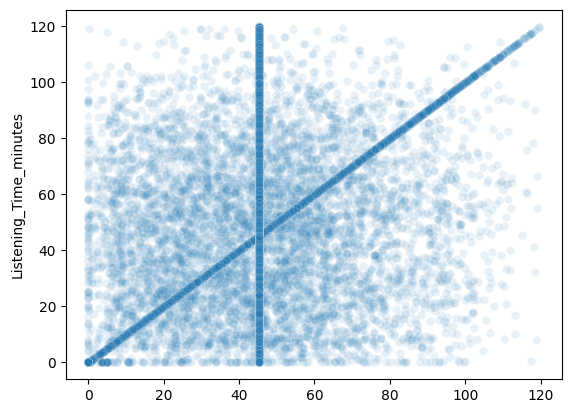

In [47]:
sns.scatterplot(
    x = tge.transform(
        df_test_1[['Episode_Title', 'Host_Popularity_percentage', 'Guest_Popularity_percentage']].astype('str').sum(axis = 1).astype('category').rename('c').to_frame()
    )[:, 0],
    y = df_test_1[target], alpha = 0.1
)
plt.show()

In [ ]:
from sklearn.base import TransformerMixin
class TargetEncoder2(TransformerMixin):
    def __init__(self, vals, max_std= 1, min_count = 2):
        self.vals = vals
        
    def fit(self, X, y = None):
        self.transformer.fit(X[self.vals], y)
        self.fitted_ = True
        return self

    def transform(self, X, **argv):
        if self.suffix is None and self.postfix is None:
            return dproc.join_and_assign(
                X, self.transformer.transform(X[self.vals])
            )
        if self.suffix is not None:
            return X.join(
                self.transformer.transform(X[self.vals], **argv).rename(columns = lambda x: self.suffix + x)
            )
        if self.postfix is not None:
            return X.join(
                self.transformer.transform(X[self.vals], **argv).rename(columns = lambda x: x + self.postfix)
            )
        return X
    
    def get_params(self, deep=True):
        return {
            "vals": self.vals, 
            "transformer": self.transformer,
            "suffix": self.suffix,
            "postfix": self.postfix
        }

    def set_output(self, transform='pandas'):
        pass

    def get_feature_names_out(self, X = None):
        vals = self.vals.copy()
        if self.suffix is not None:
            vals = [self.suffix + i for i in self.vals]
        if self.postfix is not None:
            vals = [i + self.postfix for i in self.vals]
        return vals